In [2]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import Doc2Vec
from gensim import utils
import gensim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cPickle as pkl
from random import randint
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.cross_validation import train_test_split
sns.set()
%matplotlib inline

data_path = "./data/"

In [2]:
class File2DocSpace(Doc2Vec):
    
    def __init__(self, file_name, epochs=1, size=80,
                 window=4,
                 min_count=2, workers=1,
                 alpha=0.5, min_alpha=0.025, batch_words=30,
                 train= True):
    
        self.file_name = file_name
        self.D, self.y = self.load_data()
        self.epochs = epochs
        self.dim = size
        # for scatter plot matrix functionality
        self.hues = pd.Series(self.y).map(lambda x: "blue" if x is 0 else "green")
        super(File2DocSpace, self).__init__(self.D, size=size,
                                            window=window,
                                            min_count=min_count, workers=workers,alpha=alpha,
                                            min_alpha=min_alpha, batch_words=batch_words)
        if train:
            self.train2()
            self.X = np.asarray(self.docvecs)
            self.docvecs = None # for RAM efficiency
        else:
            self.X = None

    def load_data(self):
        """
        Places data in list of labelled sentences format which
        allows gensim to build vocab automatically
        """
        with open(self.file_name) as f:
            lines = f.readlines()

        labels = list()
        all_dat = list()
        for i, l in enumerate(lines):

            labels.append(int(l[0]))

            l = gensim.utils.any2unicode(l)
            all_dat.append(LabeledSentence(l.split("\t")[-1], [i]))

        return all_dat, np.asarray(labels)
    
    def visualize_vec_as_mat(self):
        """
         Draws a set of samples from pargraph vector space
         and visualizes as a matrix
        
        """
        r1 = randint(self.dim, len(self.D) -1 )
        if self.X is not None:
            matrix = self.X[r1-self.dim:r1, :]
        else:
            matrix = np.asarray(self.docvecs)[r1-self.dim:r1, :]
        plt.matshow(matrix)
    
    
    def visualize_scatter_plot_mat(self, dim=6):
        dictio = {}
        r1 = randint(dim, (self.dim) )
        for i in range(r1-dim, r1):
            if self.X is not None:
                dictio["dimension "+ str(i)] = self.X[:,i]
            else:
                dictio["dimension "+ str(i)] = np.asarray(self.docvecs)[:,i]
        dictio["hue"] = self.hues
        df = pd.DataFrame(dictio)
        sns.pairplot(df, hue="hue")
    
    def train2(self):
        """
        Neural network SGD like trainign for paragraph vector estimation
        """
        for epoch in range(self.epochs):
            print "epoch: ", epoch
            self.train(self.D)
            self.alpha -= 0.002  # decrease the learning rate
            self.min_alpha = self.alpha  # fix the learning rate, no decay

In [13]:
model_word = File2DocSpace("training_data.txt", epochs=20, workers=4, size=20)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


In [14]:
import cPickle as pkl

with open("word_model_20_20.pkl", "wb") as f:
    pkl.dump((model_word.X,model_word.y), f)


In [3]:
with open ('word_model_20_20.pkl', 'rb') as fp:
    trained_model_word = pkl.load(fp)

model_word = File2DocSpace("training_data.txt", epochs=0, workers=4, size=20)
model_word.X = trained_model_word[0]
model_word.y = trained_model_word[1]

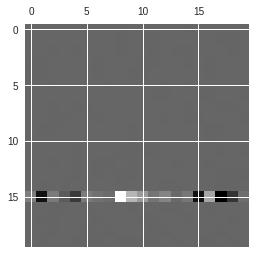

In [4]:
model_word.visualize_vec_as_mat()

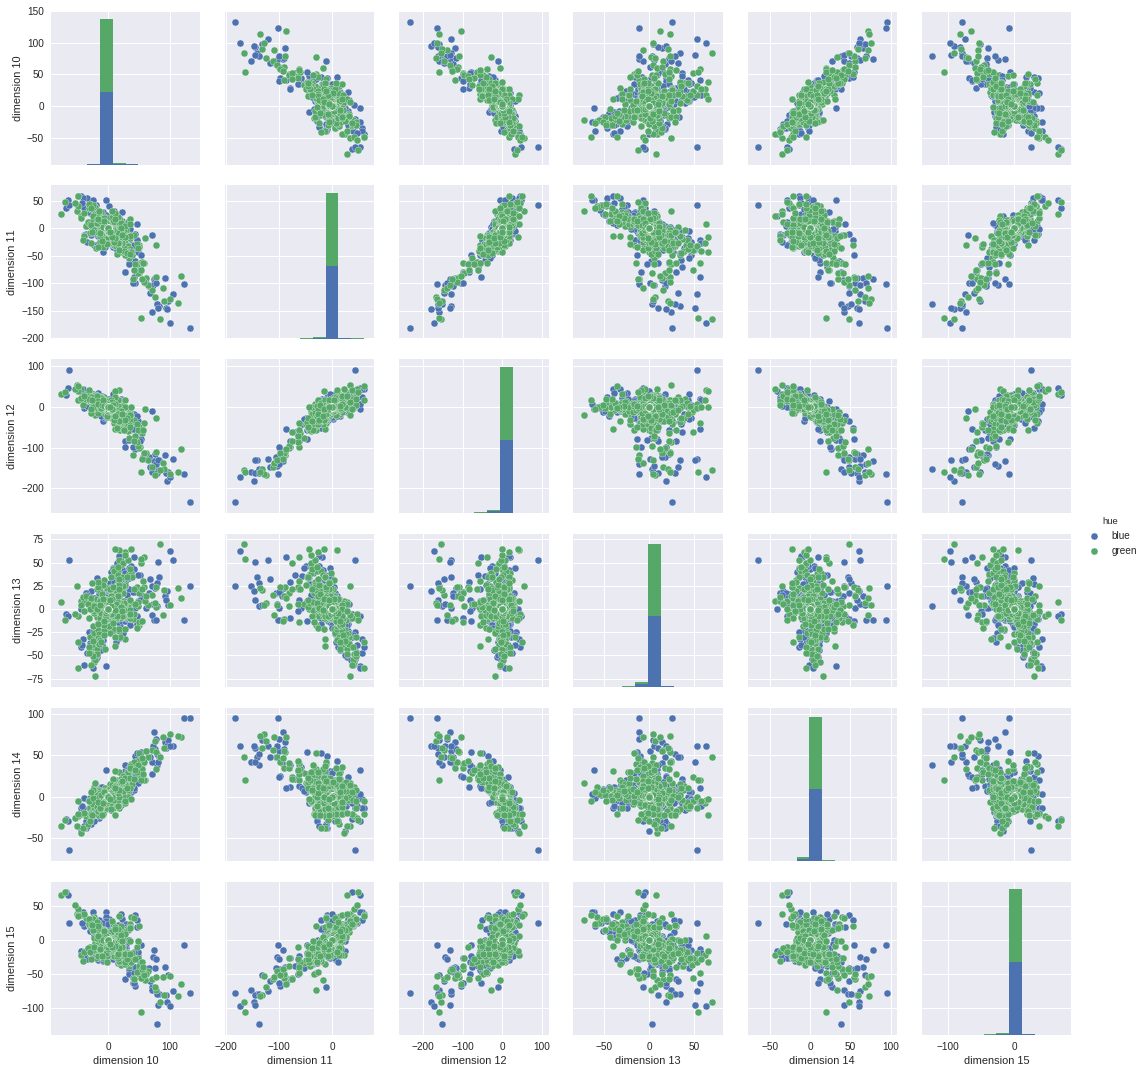

In [5]:
model_word.visualize_scatter_plot_mat()

In [ ]:
# model.X.shape
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

model = Sequential()
model.add(Dense(50, input_dim=20))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(model_word.X, model_word.y, test_size=0.33, random_state=42)
model.fit(X_train, to_categorical(y_train), 
          nb_epoch=500, batch_size=5000, validation_data=(X_test, to_categorical(y_test)))

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def load_data(file_name=data_path+"training_data.txt"):
    """
    Places data in list of labelled sentences format which
    allows gensim to build vocab automatically
    """
    with open(file_name) as f:
        lines = f.readlines()

    labels = list()
    all_dat = list()
    for i, l in enumerate(lines):

        labels.append(int(l[0]))

        l = gensim.utils.any2unicode(l)
        all_dat.append(l.split("\t")[-1].strip())

    return all_dat, np.asarray(labels)

data, labels = load_data()
#print data[0:6]

In [5]:
def load_test_data(file_name=data_path+"test_data.txt"):
    """
    Places data in list of labelled sentences format which
    allows gensim to build vocab automatically
    """
    with open(file_name) as f:
        lines = f.readlines()

    all_dat = list()
    for i, l in enumerate(lines):

        l = gensim.utils.any2unicode(l)
        all_dat.append(l)

    return all_dat

test_data = load_test_data()
#print test_data

In [6]:
vect = TfidfVectorizer(min_df=0.001)
mat = vect.fit_transform(data).toarray()
print mat.shape

pca = PCA(n_components=1650) # keep 95% variance
mat2 = pca.fit_transform(mat)
print mat2.shape

(24544, 2052)
(24544, 1650)


In [7]:
print sum(pca.explained_variance_ratio_)

0.954284824385


In [7]:
# for testing only
whole_data = data + test_data

vect = TfidfVectorizer(min_df=0.001)
mat = vect.fit_transform(whole_data).toarray()
print mat.shape


pca = PCA(n_components=1650)
mat2 = pca.fit_transform(mat)
test_mat = mat2[len(data):len(whole_data),:]
mat2 = mat2[0:len(data),:] # get the training data back
print sum(pca.explained_variance_ratio_)
print mat2.shape
print test_mat.shape

(28178, 2019)
0.95657143308
(24544, 1650)
(3634, 1650)


In [ ]:
# for testing only (2nd case) If done separately

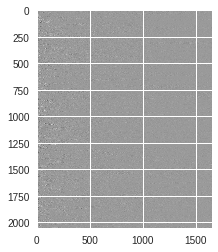

In [18]:
plt.imshow(mat2[0:1650,:])

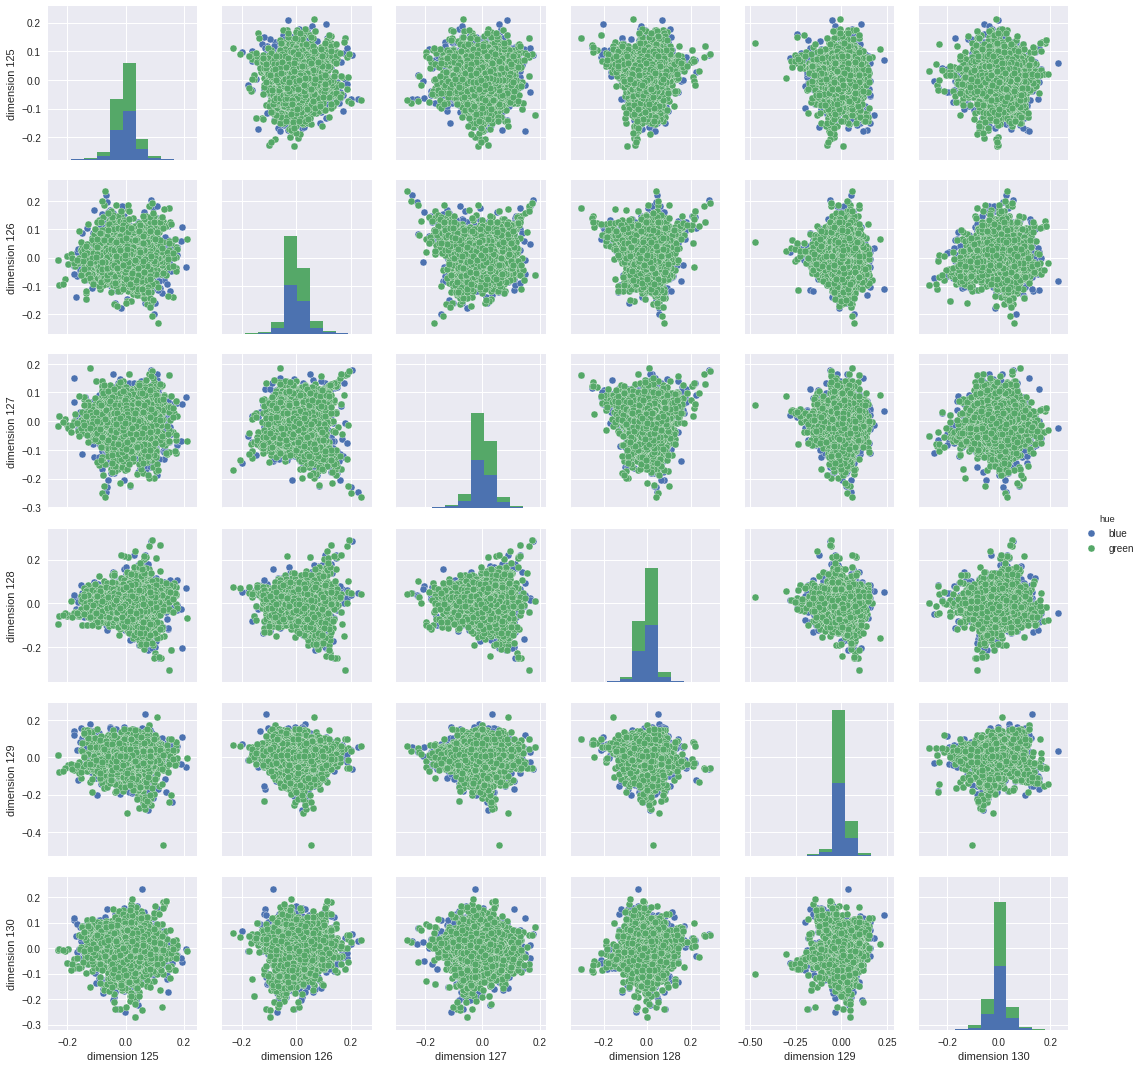

In [18]:
def visualize_scatter_plot_mat(dim=6):
    dictio = {}
    r1 = randint(dim, (2052) )
    for i in range(r1-dim, r1):
        dictio["dimension "+ str(i)] = mat2[:,i]
    dictio["hue"] = model_word.hues
    df = pd.DataFrame(dictio)
    sns.pairplot(df, hue="hue")
    
visualize_scatter_plot_mat()

In [28]:
model = Sequential()
model.add(Dense(150, input_dim=1650))
model.add(Activation('relu'))
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# X_train, X_test, y_train, y_test = train_test_split(mat2, model_word.y, test_size=0.2, random_state=42)
X_train = mat2[0:20000,:]
X_test = mat2[20000:,:]
y_train = labels[0:20000]
y_test = labels[20000:]

print y_test
# y_test = ~ y_test.astype(bool)
# y_test = y_test.astype(int)

print len(y_test), sum(y_test)
h = model.fit(X_train, to_categorical(y_train), 
          nb_epoch=100, batch_size=500, validation_data=(X_test, to_categorical(y_test)))

[0 0 1 ..., 0 0 1]
4544 2269
Train on 20000 samples, validate on 4544 samples
Epoch 1/100
20000/20000 [==============================] - 2s - loss: 0.6939 - acc: 0.4917 - val_loss: 0.6938 - val_acc: 0.4748
Epoch 2/100
20000/20000 [==============================] - 1s - loss: 0.6860 - acc: 0.5527 - val_loss: 0.7087 - val_acc: 0.4582
Epoch 3/100
20000/20000 [==============================] - 1s - loss: 0.6708 - acc: 0.5805 - val_loss: 0.7310 - val_acc: 0.4387
Epoch 4/100
20000/20000 [==============================] - 1s - loss: 0.6547 - acc: 0.6077 - val_loss: 0.7661 - val_acc: 0.4130
Epoch 5/100
20000/20000 [==============================] - 1s - loss: 0.6398 - acc: 0.6272 - val_loss: 0.8073 - val_acc: 0.3861
Epoch 6/100
20000/20000 [==============================] - 1s - loss: 0.6185 - acc: 0.6519 - val_loss: 0.8632 - val_acc: 0.3520
Epoch 7/100
20000/20000 [==============================] - 1s - loss: 0.5913 - acc: 0.6844 - val_loss: 0.9482 - val_acc: 0.3232
Epoch 8/100
20000/20000 [=

In [10]:
print h.history['val_acc'][-1]

0.254532495021


In [26]:
# res = model.predict_classes(X_test)

# print "\n", res[0:22]
# print y_test[0:22]


# res = model.predict_classes(X_train)

# print "\n", res[0:22]
# print y_train[0:22]



# res = model.predict_classes(mat2)

print "\n", res[0:22]
print labels[0:22]
print len(labels), len(res)

a = labels - res
print a[0:22]

print mat2[0:20000,:].shape


[0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0]
24544 24544
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
(20000, 1650)


In [9]:
# For test-set:
print model.predict_classes(test_mat)
final_results = model.predict_classes(test_mat)


6/6 [==============================] - 0s
[1 0 1 0 1 0]
6/6 [==============================] - 0s
[0 1 0 1 0 1]
6/6 [==============================] - 0s


In [ ]:
# with open("final_results.pkl", "wb") as f:
#     pkl.dump(final_results, f)